# Workflow for a multi-regional energy system

In this application of the ETHOS.FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The ETHOS.FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [59]:
import fine as fn
import matplotlib.pyplot as plt
from getData import getData
import pandas as pd
import os

cwd = os.getcwd()
data = getData()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [60]:
locations = {
    "cluster_0",
    "cluster_1",
    "cluster_2",
    "cluster_3",
    "cluster_4",
    "cluster_5",
    "cluster_6",
    "cluster_7",
}
commodityUnitDict = {
    "electricity": r"GW$_{el}$",
    "methane": r"GW$_{CH_{4},LHV}$",
    "biogas": r"GW$_{biogas,LHV}$",
    "CO2": r"Mio. t$_{CO_2}$/h",
    "hydrogen": r"GW$_{H_{2},LHV}$",
}
commodities = {"electricity", "hydrogen", "methane", "biogas", "CO2"}
numberOfTimeSteps = 8760
hoursPerTimeStep = 1
CO2_reductionTarget = 1
balanceLimit = pd.DataFrame(index=["CO2 limit"], columns=["Total", "lowerBound"], data=[[-366 * (1 - CO2_reductionTarget), True]])

In [61]:
esM = fn.EnergySystemModel(
    locations=locations,
    commodities=commodities,
    numberOfTimeSteps=8760,
    commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=1,
    costUnit="1e9 Euro",
    lengthUnit="km",
    verboseLogLevel=0,
    balanceLimit = balanceLimit
)

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [62]:
esM.add(
    fn.Source(
        esM=esM,
        name="Wind (onshore)",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax=data["Wind (onshore), operationRateMax"],
        capacityMax=data["Wind (onshore), capacityMax"],
        investPerCapacity=1.1,
        opexPerCapacity=1.1 * 0.02,
        interestRate=0.08,
        economicLifetime=20,
    )
)

Full load hours:

In [63]:
data["Wind (onshore), operationRateMax"].sum()

cluster_0    1572.003960
cluster_1    2350.292663
cluster_2    2374.507270
cluster_3    2186.572278
cluster_4    1572.650655
cluster_5    1767.840650
cluster_6    2719.564564
cluster_7    1553.045964
dtype: float64

### Wind offshore

In [64]:
esM.add(
    fn.Source(
        esM=esM,
        name="Wind (offshore)",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax=data["Wind (offshore), operationRateMax"],
        capacityMax=data["Wind (offshore), capacityMax"],
        investPerCapacity=2.3,
        opexPerCapacity=2.3 * 0.02,
        interestRate=0.08,
        economicLifetime=20,
    )
)

Full load hours:

In [65]:
data["Wind (offshore), operationRateMax"].sum()

cluster_0       0.000000
cluster_1    4435.420314
cluster_2    4301.655834
cluster_3    3902.391858
cluster_4       0.000000
cluster_5       0.000000
cluster_6    4609.508396
cluster_7       0.000000
dtype: float64

### PV

In [66]:
esM.add(
    fn.Source(
        esM=esM,
        name="PV",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax=data["PV, operationRateMax"],
        capacityMax=data["PV, capacityMax"],
        investPerCapacity=0.65,
        opexPerCapacity=0.65 * 0.02,
        interestRate=0.08,
        economicLifetime=25,
    )
)

Full load hours:

In [67]:
data["PV, operationRateMax"].sum()

cluster_0    1113.216464
cluster_1    1053.579422
cluster_2    1058.005181
cluster_3    1079.872237
cluster_4    1140.407380
cluster_5    1051.848141
cluster_6    1069.843344
cluster_7    1085.697466
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [68]:
esM.add(
    fn.Source(
        esM=esM,
        name="Existing run-of-river plants",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateFix=data["Existing run-of-river plants, operationRateFix"],
        tsaWeight=0.01,
        capacityFix=data["Existing run-of-river plants, capacityFix"],
        investPerCapacity=0,
        opexPerCapacity=0.208,
    )
)

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [69]:
esM.add(
    fn.Source(
        esM=esM,
        name="Natural gas purchase",
        commodity="methane",
        hasCapacityVariable=False,
        commodityCost=0.0331 * 1e-3,
    )
)

### Biogas

In [70]:
esM.add(
    fn.Source(
        esM=esM,
        name="Biogas purchase",
        commodity="biogas",
        operationRateMax=data["Biogas, operationRateMax"],
        hasCapacityVariable=False,
        commodityCost=0.05409 * 1e-3,
    )
)

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [71]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="CCGT plants (methane)",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={
            "electricity": 1,
            "methane": -1 / 0.6,
            "CO2": 201 * 1e-6 / 0.6,
        },
        hasCapacityVariable=True,
        investPerCapacity=0.65,
        opexPerCapacity=0.021,
        interestRate=0.08,
        economicLifetime=33,
    )
)

### New combined cycle gas turbine plants for biogas

In [72]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="New CCGT plants (biogas)",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": 1, "biogas": -1 / 0.63},
        hasCapacityVariable=True,
        investPerCapacity=0.7,
        opexPerCapacity=0.021,
        interestRate=0.08,
        economicLifetime=33,
    )
)

### New combined cycly gas turbines for hydrogen

In [73]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="New CCGT plants (hydrogen)",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": 1, "hydrogen": -1 / 0.63},
        hasCapacityVariable=True,
        investPerCapacity=0.7,
        opexPerCapacity=0.021,
        interestRate=0.08,
        economicLifetime=33,
    )
)

### Electrolyzers

In [74]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="Electrolyzer",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": -1, "hydrogen": 0.7},
        hasCapacityVariable=True,
        investPerCapacity=0.5,
        opexPerCapacity=0.5 * 0.025,
        interestRate=0.08,
        economicLifetime=10,
    )
)

### rSOC

In [75]:
capexRSOC = 1.5

esM.add(
    fn.Conversion(
        esM=esM,
        name="rSOEC",
        physicalUnit=r"GW$_{el}$",
        linkedConversionCapacityID="rSOC",
        commodityConversionFactors={"electricity": -1, "hydrogen": 0.6},
        hasCapacityVariable=True,
        investPerCapacity=capexRSOC / 2,
        opexPerCapacity=capexRSOC * 0.02 / 2,
        interestRate=0.08,
        economicLifetime=10,
    )
)

esM.add(
    fn.Conversion(
        esM=esM,
        name="rSOFC",
        physicalUnit=r"GW$_{el}$",
        linkedConversionCapacityID="rSOC",
        commodityConversionFactors={"electricity": 1, "hydrogen": -1 / 0.6},
        hasCapacityVariable=True,
        investPerCapacity=capexRSOC / 2,
        opexPerCapacity=capexRSOC * 0.02 / 2,
        interestRate=0.08,
        economicLifetime=10,
    )
)

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [76]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Li-ion batteries",
        commodity="electricity",
        hasCapacityVariable=True,
        chargeEfficiency=0.95,
        cyclicLifetime=10000,
        dischargeEfficiency=0.95,
        selfDischarge=1 - (1 - 0.03) ** (1 / (30 * 24)),
        chargeRate=1,
        dischargeRate=1,
        doPreciseTsaModeling=False,
        investPerCapacity=0.151,
        opexPerCapacity=0.002,
        interestRate=0.08,
        economicLifetime=22,
    )
)

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [77]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Salt caverns (hydrogen)",
        commodity="hydrogen",
        hasCapacityVariable=True,
        capacityVariableDomain="continuous",
        capacityPerPlantUnit=133,
        chargeRate=1 / 470.37,
        dischargeRate=1 / 470.37,
        sharedPotentialID="Existing salt caverns",
        stateOfChargeMin=0.33,
        stateOfChargeMax=1,
        capacityMax=data["Salt caverns (hydrogen), capacityMax"],
        investPerCapacity=0.00011,
        opexPerCapacity=0.00057,
        interestRate=0.08,
        economicLifetime=30,
    )
)

## 5.3. Methane storage

### Methane filled salt caverns

In [78]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Salt caverns (biogas)",
        commodity="biogas",
        hasCapacityVariable=True,
        capacityVariableDomain="continuous",
        capacityPerPlantUnit=443,
        chargeRate=1 / 470.37,
        dischargeRate=1 / 470.37,
        sharedPotentialID="Existing salt caverns",
        stateOfChargeMin=0.33,
        stateOfChargeMax=1,
        capacityMax=data["Salt caverns (methane), capacityMax"],
        investPerCapacity=0.00004,
        opexPerCapacity=0.00001,
        interestRate=0.08,
        economicLifetime=30,
    )
)

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [79]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Pumped hydro storage",
        commodity="electricity",
        chargeEfficiency=0.88,
        dischargeEfficiency=0.88,
        hasCapacityVariable=True,
        selfDischarge=1 - (1 - 0.00375) ** (1 / (30 * 24)),
        chargeRate=0.16,
        dischargeRate=0.12,
        capacityFix=data["Pumped hydro storage, capacityFix"],
        investPerCapacity=0,
        opexPerCapacity=0.000153,
    )
)

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [80]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="AC cables",
        commodity="electricity",
        hasCapacityVariable=True,
        capacityFix=data["AC cables, capacityFix"],
    )
)

The distances of a component are set to a normalized value of 1.


### DC cables

In [81]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="DC cables",
        commodity="electricity",
        losses=data["DC cables, losses"],
        distances=data["DC cables, distances"],
        hasCapacityVariable=True,
        capacityFix=data["DC cables, capacityFix"],
    )
)

## 6.2 Methane transmission

### Methane pipeline

In [82]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="Pipelines (biogas)",
        commodity="biogas",
        distances=data["Pipelines, distances"],
        hasCapacityVariable=True,
        hasIsBuiltBinaryVariable=True,
        bigM=300,
        locationalEligibility=data["Pipelines, eligibility"],
        capacityMax=data["Pipelines, eligibility"] * 15,
        sharedPotentialID="pipelines",
        investPerCapacity=0.000037,
        investIfBuilt=0.000314,
        interestRate=0.08,
        economicLifetime=40,
    )
)

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [83]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="Pipelines (hydrogen)",
        commodity="hydrogen",
        distances=data["Pipelines, distances"],
        hasCapacityVariable=True,
        hasIsBuiltBinaryVariable=True,
        bigM=300,
        locationalEligibility=data["Pipelines, eligibility"],
        capacityMax=data["Pipelines, eligibility"] * 15,
        sharedPotentialID="pipelines",
        investPerCapacity=0.000177,
        investIfBuilt=0.00033,
        interestRate=0.08,
        economicLifetime=40,
    )
)

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [84]:
esM.add(
    fn.Sink(
        esM=esM,
        name="Electricity demand",
        commodity="electricity",
        hasCapacityVariable=False,
        operationRateFix=data["Electricity demand, operationRateFix"],
    )
)

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [85]:
FCEV_penetration = 0.5
esM.add(
    fn.Sink(
        esM=esM,
        name="Hydrogen demand",
        commodity="hydrogen",
        hasCapacityVariable=False,
        operationRateFix=data["Hydrogen demand, operationRateFix"] * FCEV_penetration,
    )
)

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [86]:
esM.add(
    fn.Sink(
        esM=esM,
        name="CO2 to enviroment",
        commodity="CO2",
        hasCapacityVariable=False,
        balanceLimitID = "CO2 limit"
    )
)

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

# 8 Temporal Aggregation

In [87]:
esM.aggregateTemporally(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period 
further clustered to 12 segments per period...
		(11.0519 sec)



### Optimization

In [88]:
# The `optimizationSpecs` only work with the Gurobi solver. If you are using another solver you need to choose
# specs spcecific to this solver or no specs.
esM.optimize(
    timeSeriesAggregation=True,
    optimizationSpecs="OptimalityTol=1e-3 method=2 cuts=0 MIPGap=5e-3",
)

Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24, number of segments per period:12

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2743 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1156 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.3669 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1920 sec)

Declaring shared potential constraint...
		(0.0014 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.3896 sec)

		(0.0021 sec)

Declaring objective function...
		(1.4183 sec)

Either solver not selected 

/fast/home/k-okosun/iek3-models/fine/fine/storage.py:1984: UserWarning: Charge and discharge at the same time for component Li-ion batteries
  warnings.warn(
/fast/home/k-okosun/iek3-models/fine/fine/storage.py:1984: UserWarning: Charge and discharge at the same time for component Pumped hydro storage
  warnings.warn(
/fast/home/k-okosun/iek3-models/fine/fine/storage.py:1984: UserWarning: Charge and discharge at the same time for component Salt caverns (biogas)
  warnings.warn(
/fast/home/k-okosun/iek3-models/fine/fine/storage.py:1984: UserWarning: Charge and discharge at the same time for component Salt caverns (hydrogen)
  warnings.warn(


for StorageModel ...       (1.2716sec)
for TransmissionModel ...  (1.0001sec)
		(3.9387 sec)



# 9. Selected results output

Plot locations (GeoPandas required)

In [89]:
# Import the geopandas package for plotting the locations
import geopandas as gpd

In [90]:
locFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "clusteredRegions.shp"
)

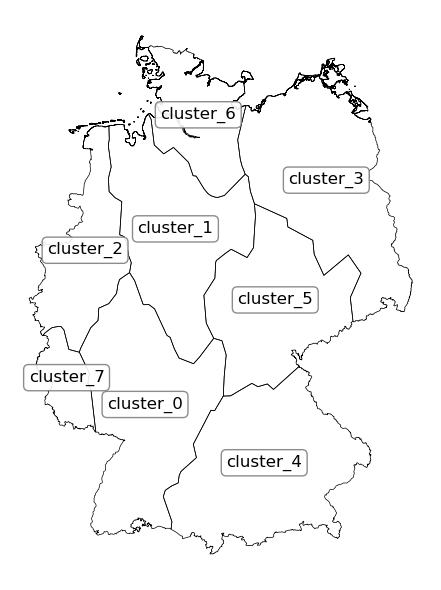

In [91]:
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn="index")

### Sources and Sink

Show optimization summary

In [92]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0  \
Component                    Property        Unit                                     
Biogas purchase              NPVcontribution [1e9 Euro]                    0.264223   
                             TAC             [1e9 Euro/a]                  0.264223   
                             commodCosts     [1e9 Euro/a]                  0.264223   
                             operation       [GW$_{biogas,LHV}$*h/a]    4884.879301   
                                             [GW$_{biogas,LHV}$*h]      4884.879301   
Electricity demand           operation       [GW$_{el}$*h/a]          133963.451433   
                                             [GW$_{el}$*h]            133963.451433   
Existing run-of-river plants NPVcontribution [1e9 Euro]                    0.144316   
                             TAC             [1e9 Euro/a]                  0.144316   
                             capacity        [GW$_{el}$]                   0.693828   
                             commissioning   [GW$_{el}$]                   0.693828   
                             operation       [GW$_{el}$*h/a]            3167.329183   
                                             [GW$_{el}$*h]              3167.329183   
                             opexCap         [1e9 Euro/a]                  0.144316   
Hydrogen demand              operation       [GW$_{H_{2},LHV}$*h/a]    15855.229091   
                                             [GW$_{H_{2},LHV}$*h]      15855.229091   
PV                           NPVcontribution [1e9 Euro]                    3.200554   
                             TAC             [1e9 Euro/a]                  3.200554   
                             capacity        [GW$_{el}$]                  43.314414   
                             capexCap        [1e9 Euro/a]                  2.637467   
                             commissioning   [GW$_{el}$]                  43.314414   
                             invest          [1e9 Euro]                   28.154369   
                             operation       [GW$_{el}$*h/a]           44237.691578   
                                             [GW$_{el}$*h]             44237.691578   
                             opexCap         [1e9 Euro/a]                  0.563087   
Wind (offshore)              NPVcontribution [1e9 Euro]                           0   
                             TAC             [1e9 Euro/a]                         0   
                             capacity        [GW$_{el}$]                        NaN   
                             capexCap        [1e9 Euro/a]                       NaN   
                             commissioning   [GW$_{el}$]                        NaN   
                             invest          [1e9 Euro]                         NaN   
                             operation       [GW$_{el}$*h/a]                    NaN   
                                             [GW$_{el}$*h]                      NaN   
                             opexCap         [1e9 Euro/a]                       NaN   
Wind (onshore)               NPVcontribution [1e9 Euro]                         0.0   
                             TAC             [1e9 Euro/a]                       0.0   
                             capacity        [GW$_{el}$]                        0.0   
                             capexCap        [1e9 Euro/a]                       0.0   
                             commissioning   [GW$_{el}$]                        0.0   
                             invest          [1e9 Euro]                         0.0   
                             operation       [GW$_{el}$*h/a]                    0.0   
                                             [GW$_{el}$*h]                      0.0   
                             opexCap         [1e9 Euro/a]                       0.0   

                                                                         cluster_1  \
Component                    Property        Unit                       

Plot installed capacities

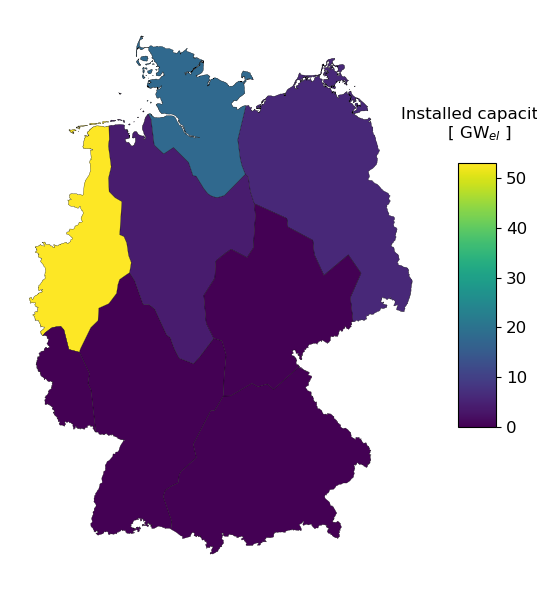

In [35]:
fig, ax = fn.plotLocationalColorMap(
    esM, "Wind (offshore)", locFilePath, "index", perArea=False
)

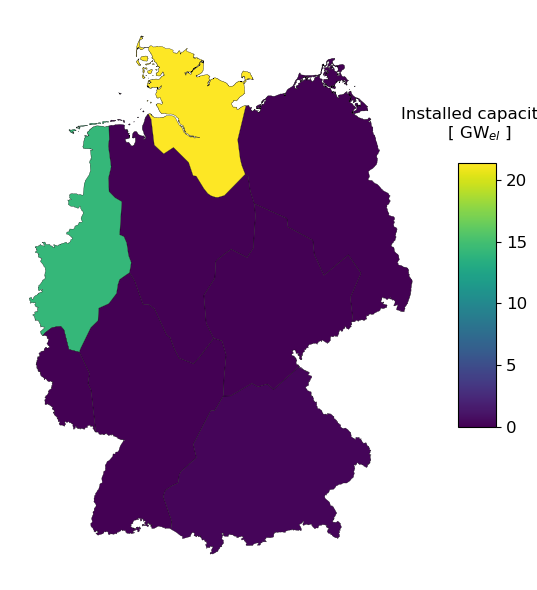

In [36]:
fig, ax = fn.plotLocationalColorMap(
    esM, "Wind (onshore)", locFilePath, "index", perArea=False
)

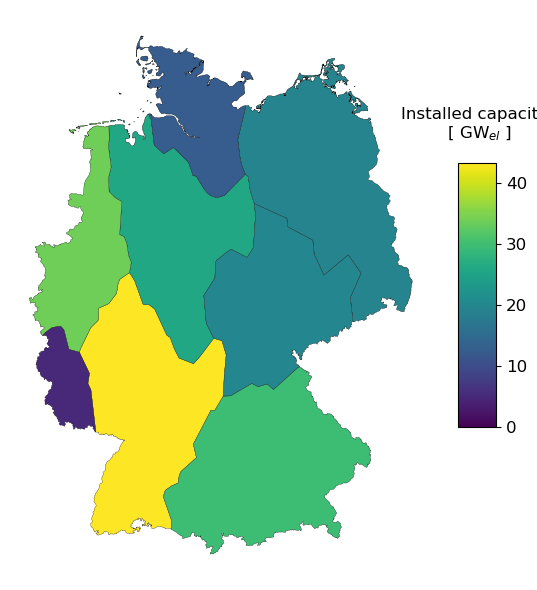

In [37]:
fig, ax = fn.plotLocationalColorMap(esM, "PV", locFilePath, "index", perArea=False)

Plot operation time series (either one or two dimensional)

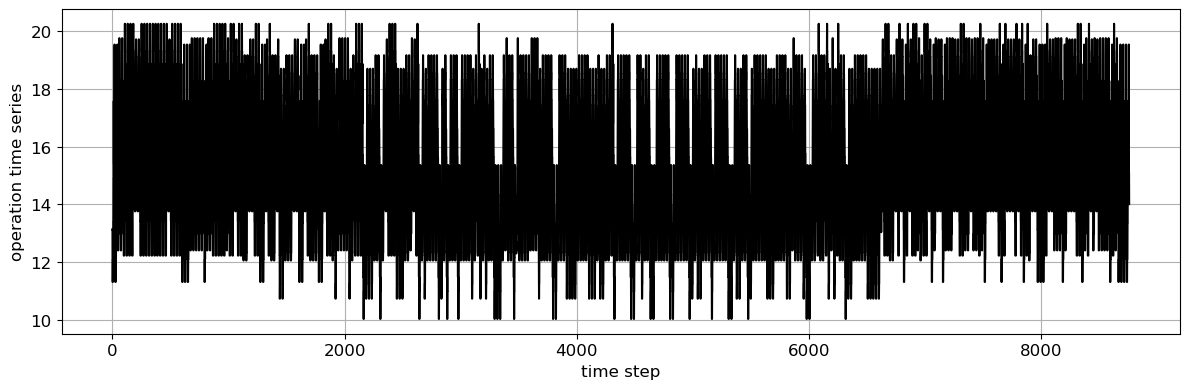

In [38]:
fig, ax = fn.plotOperation(esM, "Electricity demand", "cluster_0")

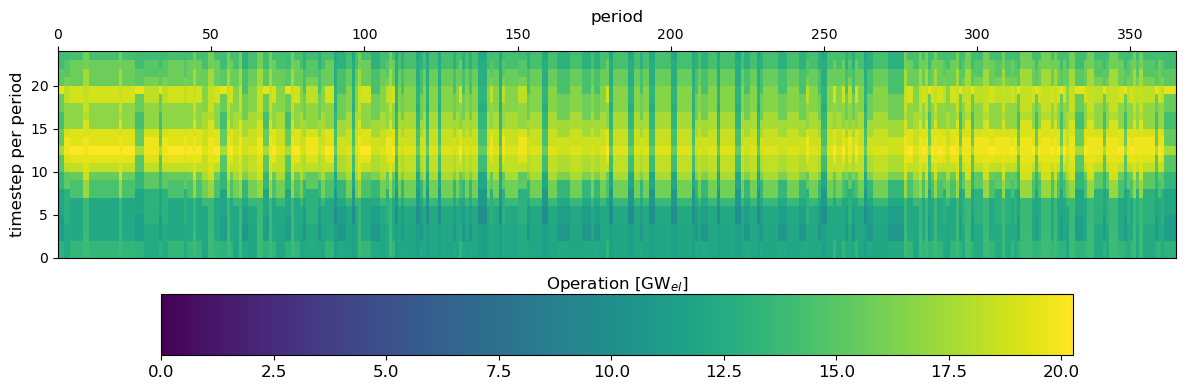

In [39]:
fig, ax = fn.plotOperationColorMap(esM, "Electricity demand", "cluster_0")

### Conversion

Show optimization summary

In [40]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

cluster_0  \
Component                Property        Unit                           
Electrolyzer             NPVcontribution [1e9 Euro]          0.023246   
                         TAC             [1e9 Euro/a]        0.023246   
                         capacity        [GW$_{el}$]         0.267148   
                         capexCap        [1e9 Euro/a]        0.019906   
                         commissioning   [GW$_{el}$]         0.267148   
                         invest          [1e9 Euro]          0.133574   
                         operation       [GW$_{el}$*h/a]   688.440191   
                                         [GW$_{el}$*h]     688.440191   
                         opexCap         [1e9 Euro/a]        0.003339   
New CCGT plants (biogas) NPVcontribution [1e9 Euro]          0.084568   
                         TAC             [1e9 Euro/a]        0.084568   
                         capacity        [GW$_{el}$]         1.033893   
                         capexCap        [1e9 Euro/a]        0.062857   
                         commissioning   [GW$_{el}$]         1.033893   
                         invest          [1e9 Euro]          0.723725   
                         operation       [GW$_{el}$*h/a]  1928.272553   
                                         [GW$_{el}$*h]    1928.272553   
                         opexCap         [1e9 Euro/a]        0.021712   

                                                            cluster_1  \
Component                Property        Unit                           
Electrolyzer             NPVcontribution [1e9 Euro]          0.215879   
                         TAC             [1e9 Euro/a]        0.215879   
                         capacity        [GW$_{el}$]         2.480953   
                         capexCap        [1e9 Euro/a]        0.184868   
                         commissioning   [GW$_{el}$]         2.480953   
                         invest          [1e9 Euro]          1.240476   
                         operation       [GW$_{el}$*h/a]  6887.201678   
                                         [GW$_{el}$*h]    6887.201678   
                         opexCap         [1e9 Euro/a]        0.031012   
New CCGT plants (biogas) NPVcontribution [1e9 Euro]          0.231581   
                         TAC             [1e9 Euro/a]        0.231581   
                         capacity        [GW$_{el}$]         2.831195   
                         capexCap        [1e9 Euro/a]        0.172126   
                         commissioning   [GW$_{el}$]         2.831195   
                         invest          [1e9 Euro]          1.981837   
                         operation       [GW$_{el}$*h/a]  4875.826629   
                                         [GW$_{el}$*h]    4875.826629   
                         opexCap         [1e9 Euro/a]        0.059455   

                                                             cluster_2  \
Component                Property        Unit                            
Electrolyzer             NPVcontribution [1e9 Euro]           1.081641   
                         TAC             [1e9 Euro/a]         1.081641   
                         capacity        [GW$_{el}$]         12.430551   
                         capexCap        [1e9 Euro/a]         0.926259   
                         commissioning   [GW$_{el}$]         12.430551   
                         invest          [1e9 Euro]           6.215276   
                         operation       [GW$_{el}$*h/a]  41341.570942   
                                         [GW$_{el}$*h]    41341.570942   
                         opexCap         [1e9 Euro/a]         0.155382   
New CCGT plants (biogas) NPVcontribution [1e9 Euro]           0.240292   
                         TAC             [1e9 Euro/a]         0.240292   
                         capacity        [GW$_{el}$]          2.937698   
                         capexCap        [1e9 Euro/a]         0.178601   
                         com

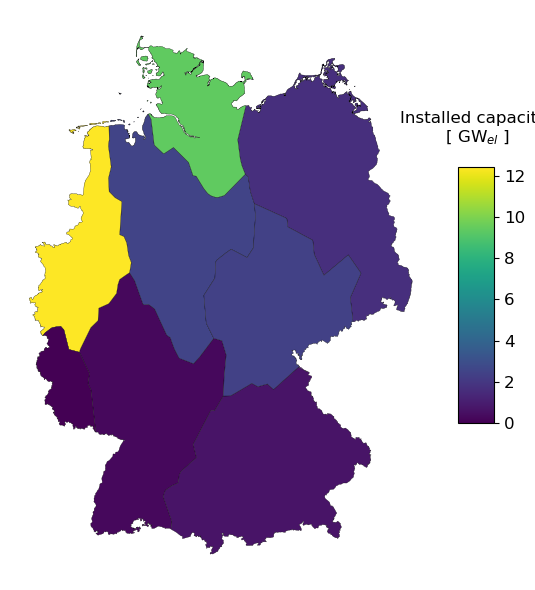

In [41]:
fig, ax = fn.plotLocationalColorMap(
    esM, "Electrolyzer", locFilePath, "index", perArea=False
)

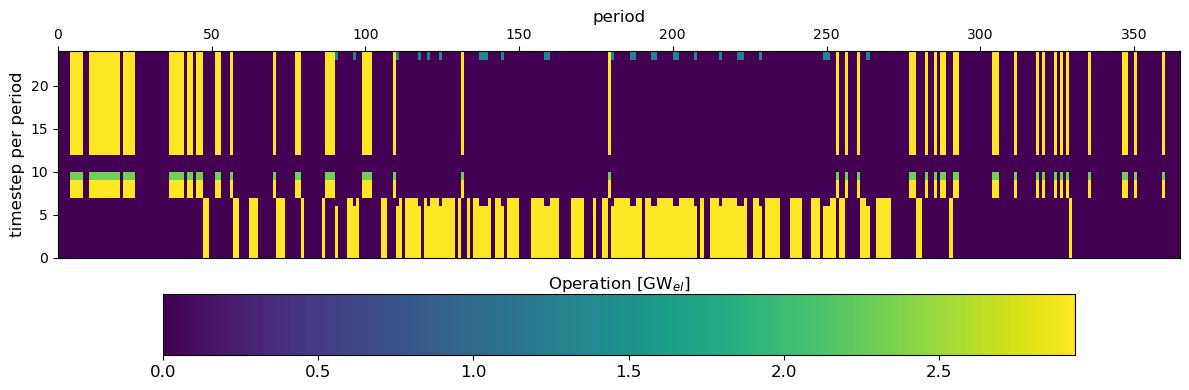

In [42]:
fig, ax = fn.plotOperationColorMap(esM, "New CCGT plants (biogas)", "cluster_2")

### Storage

Show optimization summary

In [43]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

cluster_0  \
Component               Property           Unit                                   
Li-ion batteries        NPVcontribution    [1e9 Euro]                  0.126031   
                        TAC                [1e9 Euro/a]                0.126031   
                        capacity           [GW$_{el}$*h]               7.500596   
                        capexCap           [1e9 Euro/a]                 0.11103   
                        commissioning      [GW$_{el}$*h]               7.500596   
                        invest             [1e9 Euro]                   1.13259   
                        operationCharge    [GW$_{el}$*h/a]          2835.661105   
                                           [GW$_{el}$*h]            2835.661105   
                        operationDischarge [GW$_{el}$*h/a]          2558.220658   
                                           [GW$_{el}$*h]            2558.220658   
                        opexCap            [1e9 Euro/a]                0.015001   
Pumped hydro storage    NPVcontribution    [1e9 Euro]                  0.002436   
                        TAC                [1e9 Euro/a]                0.002436   
                        capacity           [GW$_{el}$*h]                 15.924   
                        commissioning      [GW$_{el}$*h]                 15.924   
                        operationCharge    [GW$_{el}$*h/a]          5345.578758   
                                           [GW$_{el}$*h]            5345.578758   
                        operationDischarge [GW$_{el}$*h/a]          4139.291399   
                                           [GW$_{el}$*h]            4139.291399   
                        opexCap            [1e9 Euro/a]                0.002436   
Salt caverns (biogas)   NPVcontribution    [1e9 Euro]                         0   
                        TAC                [1e9 Euro/a]                       0   
                        capacity           [GW$_{biogas,LHV}$*h]            NaN   
                        capexCap           [1e9 Euro/a]                     NaN   
                        commissioning      [GW$_{biogas,LHV}$*h]            NaN   
                        invest             [1e9 Euro]                       NaN   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]          NaN   
                                           [GW$_{biogas,LHV}$*h]            NaN   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]          NaN   
                                           [GW$_{biogas,LHV}$*h]            NaN   
                        opexCap            [1e9 Euro/a]                     NaN   
Salt caverns (hydrogen) NPVcontribution    [1e9 Euro]                         0   
                        TAC                [1e9 Euro/a]                       0   
                        capacity           [GW$_{H_{2},LHV}$*h]             NaN   
                        capexCap           [1e9 Euro/a]                     NaN   
                        commissioning      [GW$_{H_{2},LHV}$*h]             NaN   
                        invest             [1e9 Euro]                       NaN   
                        operationCharge    [GW$_{H_{2},LHV}$*h/a]           NaN   
                                           [GW$_{H_{2},LHV}$*h]             NaN   
                        operationDischarge [GW$_{H_{2},LHV}$*h/a]           NaN   
                                           [GW$_{H_{2},LHV}$*h]             NaN   
                        opexCap            [1e9 Euro/a]                     NaN   

                                                                      cluster_1  \
Component               Property           Unit                                   
Li-ion batteries        NPVcontribution    [1e9 Euro]                  0.215917   
                        TAC                [1e9 Euro/a]                0.215917   
                        capacity           [GW$_{el}$*h]              12.850024   
  

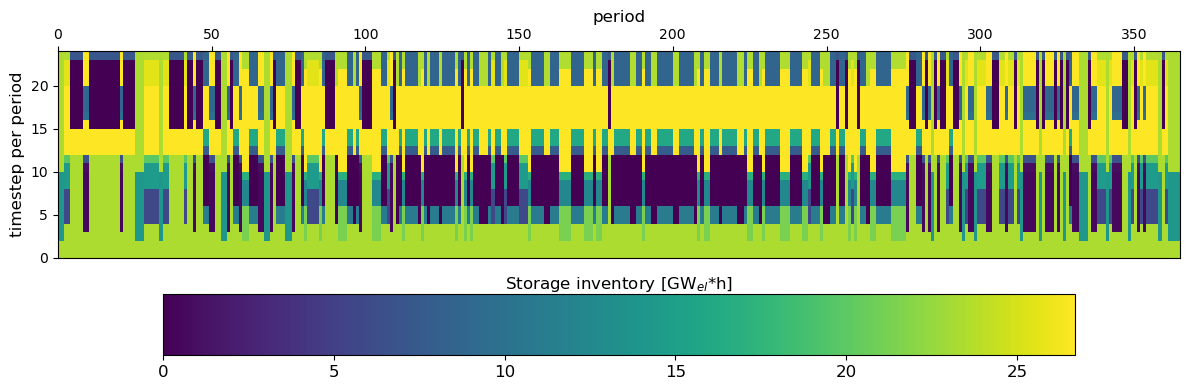

In [44]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Li-ion batteries",
    "cluster_2",
    variableName="stateOfChargeOperationVariablesOptimum",
)

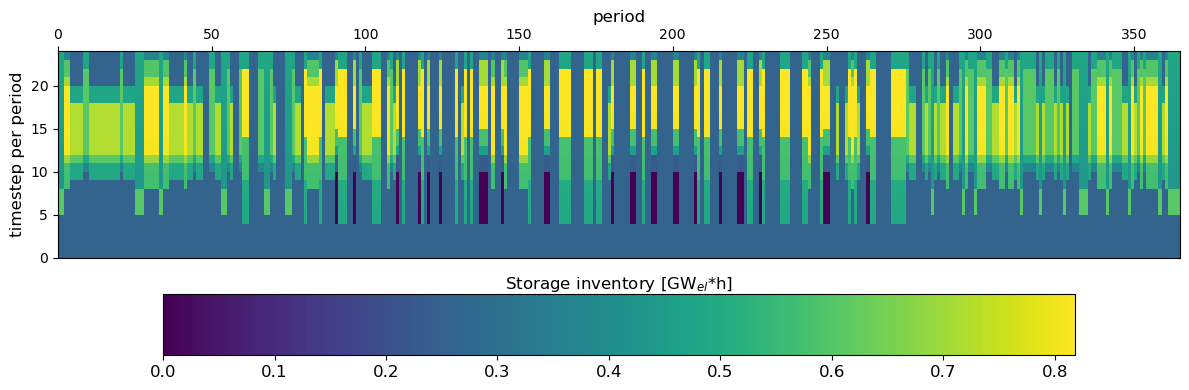

In [45]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Pumped hydro storage",
    "cluster_2",
    variableName="stateOfChargeOperationVariablesOptimum",
)

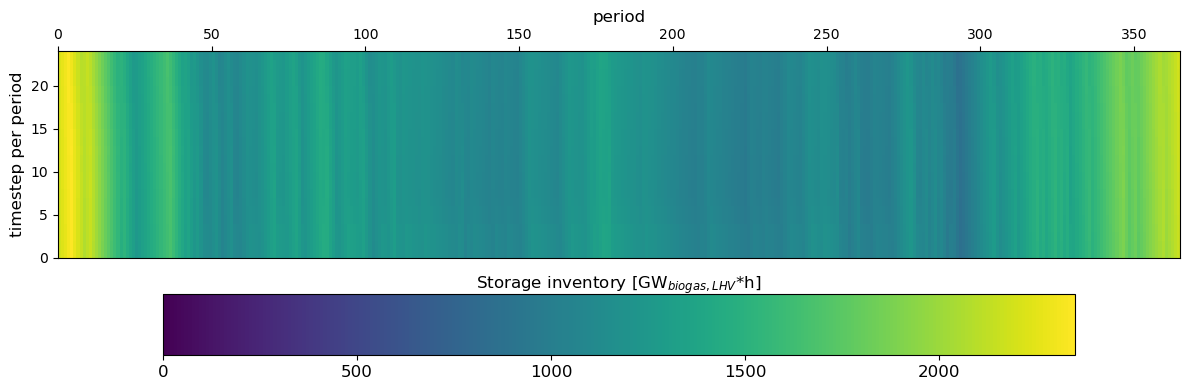

In [46]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Salt caverns (biogas)",
    "cluster_2",
    variableName="stateOfChargeOperationVariablesOptimum",
)

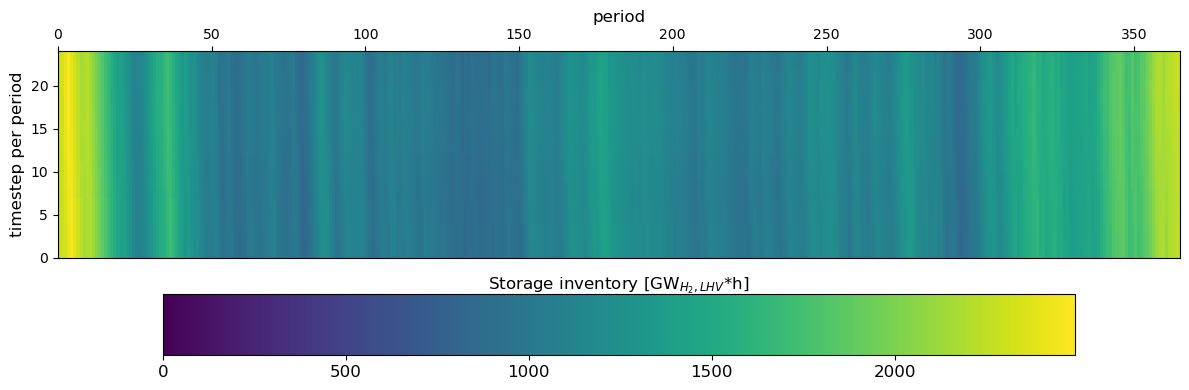

In [47]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Salt caverns (hydrogen)",
    "cluster_2",
    variableName="stateOfChargeOperationVariablesOptimum",
)

## Transmission

Show optimization summary

In [48]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

cluster_0  \
Component            Property  Unit                 LocationIn                 
AC cables            capacity  [GW$_{el}$]          cluster_0            NaN   
                                                    cluster_1            7.0   
                                                    cluster_2           11.0   
                                                    cluster_3            NaN   
                                                    cluster_4           18.0   
...                                                                      ...   
Pipelines (hydrogen) operation [GW$_{H_{2},LHV}$*h] cluster_0            NaN   
                                                    cluster_1   12650.265571   
                                                    cluster_2   11007.517783   
                                                    cluster_3            NaN   
                                                    cluster_6            NaN   

                                                                   cluster_1  \
Component            Property  Unit                 LocationIn                 
AC cables            capacity  [GW$_{el}$]          cluster_0            7.0   
                                                    cluster_1            NaN   
                                                    cluster_2           10.0   
                                                    cluster_3            NaN   
                                                    cluster_4            NaN   
...                                                                      ...   
Pipelines (hydrogen) operation [GW$_{H_{2},LHV}$*h] cluster_0       5.049096   
                                                    cluster_1            NaN   
                                                    cluster_2      57.051806   
                                                    cluster_3            0.0   
                                                    cluster_6   23317.189647   

                                                               cluster_2  \
Component            Property  Unit                 LocationIn             
AC cables            capacity  [GW$_{el}$]          cluster_0       11.0   
                                                    cluster_1       10.0   
                                                    cluster_2        NaN   
                                                    cluster_3        NaN   
                                                    cluster_4        NaN   
...                                                                  ...   
Pipelines (hydrogen) operation [GW$_{H_{2},LHV}$*h] cluster_0        0.0   
                                                    cluster_1   31.18904   
                                                    cluster_2        NaN   
                                                    cluster_3        NaN   
                                                    cluster_6        NaN   

                                                                  cluster_3  \
Component            Property  Unit                 LocationIn                
AC cables            capacity  [GW$_{el}$]          cluster_0           NaN   
                                                    cluster_1           NaN   
                                                    cluster_2           NaN   
                                                    cluster_3           NaN   
                                                    cluster_4           NaN   
...                                                                     ...   
Pipelines (hydrogen) operation [GW$_{H_{2},LHV}$*h] cluster_0           NaN   
                                                    cluster_1           0.0   
                                                    cluster_2           NaN   
                                                    cluster_3           NaN   
                                                

In [49]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc[
    "Pipelines (hydrogen)"
]

cluster_0     cluster_1  \
Property        Unit                 LocationIn                               
NPVcontribution [1e9 Euro]           cluster_0              0       0.00956   
                                     cluster_1        0.00956             0   
                                     cluster_2       0.007999      0.002787   
                                     cluster_3              0           0.0   
                                     cluster_4       0.006892             0   
...                                                       ...           ...   
operation       [GW$_{H_{2},LHV}$*h] cluster_0            NaN      5.049096   
                                     cluster_1   12650.265571           NaN   
                                     cluster_2   11007.517783     57.051806   
                                     cluster_3            NaN           0.0   
                                     cluster_6            NaN  23317.189647   

                                                cluster_2    cluster_3  \
Property        Unit                 LocationIn                          
NPVcontribution [1e9 Euro]           cluster_0   0.007999            0   
                                     cluster_1   0.002787          0.0   
                                     cluster_2          0            0   
                                     cluster_3          0            0   
                                     cluster_4          0            0   
...                                                   ...          ...   
operation       [GW$_{H_{2},LHV}$*h] cluster_0        0.0          NaN   
                                     cluster_1   31.18904          0.0   
                                     cluster_2        NaN          NaN   
                                     cluster_3        NaN          NaN   
                                     cluster_6        NaN  2280.084691   

                                                   cluster_4 cluster_5  \
Property        Unit                 LocationIn                          
NPVcontribution [1e9 Euro]           cluster_0      0.006892       0.0   
                                     cluster_1             0       0.0   
                                     cluster_2             0         0   
                                     cluster_3             0       0.0   
                                     cluster_4             0       0.0   
...                                                      ...       ...   
operation       [GW$_{H_{2},LHV}$*h] cluster_0   8279.413302       0.0   
                                     cluster_1           NaN       0.0   
                                     cluster_2           NaN       NaN   
                                     cluster_3           NaN       0.0   
                                     cluster_6           NaN       NaN   

                                                  cluster_6    cluster_7  
Property        Unit                 LocationIn                           
NPVcontribution [1e9 Euro]           cluster_0            0          0.0  
                                     cluster_1     0.011553            0  
                                     cluster_2            0     0.005982  
                                     cluster_3     0.007026            0  
                                     cluster_4            0            0  
...                                                     ...          ...  
operation       [GW$_{H_{2},LHV}$*h] cluster_0          NaN          0.0  
                                     cluster_1   4511.82023          NaN  
                                     cluster_2          NaN  1453.124166  
                                     cluster_3   406.772776          NaN  
                                     cluster_6          NaN          NaN  

[66 rows x 8 columns]

Check that the shared capacity of the pipelines are not exceeded

In [50]:
df = esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc["Pipelines (biogas)"] + df.loc["Pipelines (hydrogen)"]

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
cluster_0,NaN,1.617008,2.426901,NaN,1.676317,0.0000,NaN,0.000000
cluster_1,1.617008,NaN,0.013484,0.000000,NaN,0.0000,3.587165,NaN
cluster_2,2.426901,0.013484,NaN,NaN,NaN,NaN,NaN,0.305141
cluster_3,NaN,0.000000,NaN,NaN,NaN,0.0000,0.600928,NaN
cluster_4,1.676317,NaN,NaN,NaN,NaN,0.2159,NaN,NaN
cluster_5,0.000000,0.000000,NaN,0.000000,0.215900,NaN,NaN,NaN
cluster_6,NaN,3.587165,NaN,0.600928,NaN,NaN,NaN,NaN
cluster_7,0.000000,NaN,0.305141,NaN,NaN,NaN,NaN,NaN


Plot installed transmission capacities

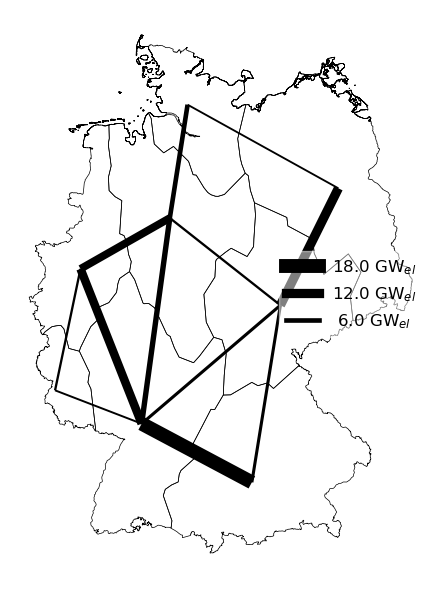

In [51]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "AClines.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "AC cables", transFilePath, loc0="bus0", loc1="bus1", fig=fig, ax=ax
)

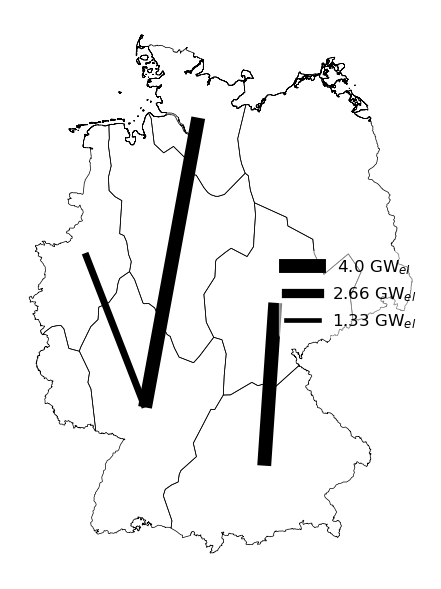

In [52]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "DClines.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "DC cables", transFilePath, loc0="cluster0", loc1="cluster1", fig=fig, ax=ax
)

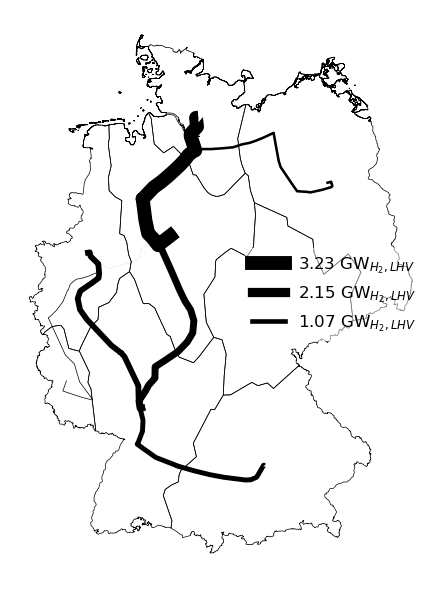

In [53]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "transmissionPipeline.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "Pipelines (hydrogen)", transFilePath, loc0="loc1", loc1="loc2", fig=fig, ax=ax
)

In [54]:
df = esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc["Pipelines (biogas)"] + df.loc["Pipelines (hydrogen)"]

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
cluster_0,NaN,1.617008,2.426901,NaN,1.676317,0.0000,NaN,0.000000
cluster_1,1.617008,NaN,0.013484,0.000000,NaN,0.0000,3.587165,NaN
cluster_2,2.426901,0.013484,NaN,NaN,NaN,NaN,NaN,0.305141
cluster_3,NaN,0.000000,NaN,NaN,NaN,0.0000,0.600928,NaN
cluster_4,1.676317,NaN,NaN,NaN,NaN,0.2159,NaN,NaN
cluster_5,0.000000,0.000000,NaN,0.000000,0.215900,NaN,NaN,NaN
cluster_6,NaN,3.587165,NaN,0.600928,NaN,NaN,NaN,NaN
cluster_7,0.000000,NaN,0.305141,NaN,NaN,NaN,NaN,NaN


Plot installed transmission capacities

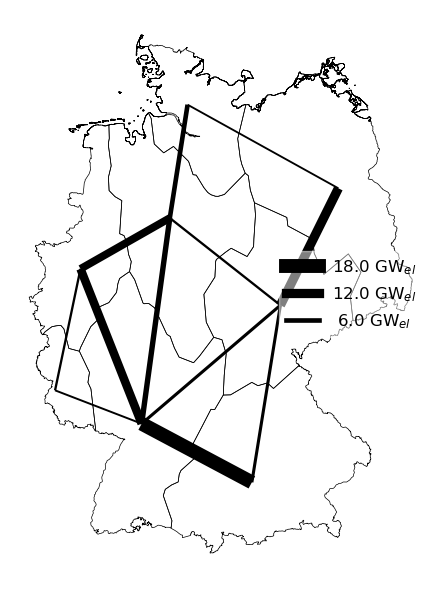

In [55]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "AClines.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "AC cables", transFilePath, loc0="bus0", loc1="bus1", fig=fig, ax=ax
)

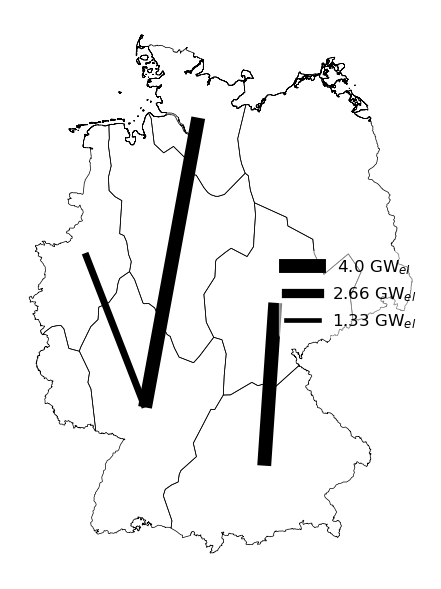

In [56]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "DClines.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "DC cables", transFilePath, loc0="cluster0", loc1="cluster1", fig=fig, ax=ax
)

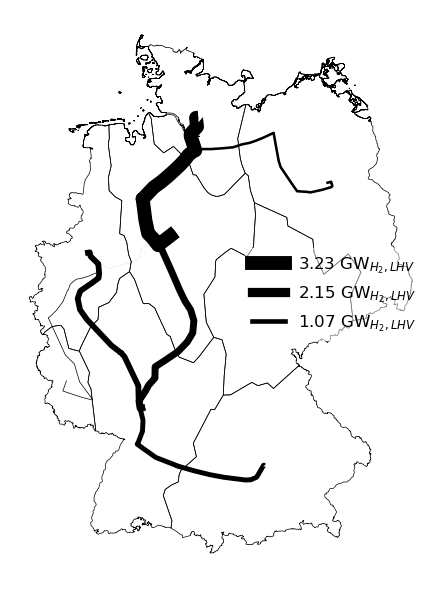

In [57]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "transmissionPipeline.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "Pipelines (hydrogen)", transFilePath, loc0="loc1", loc1="loc2", fig=fig, ax=ax
)

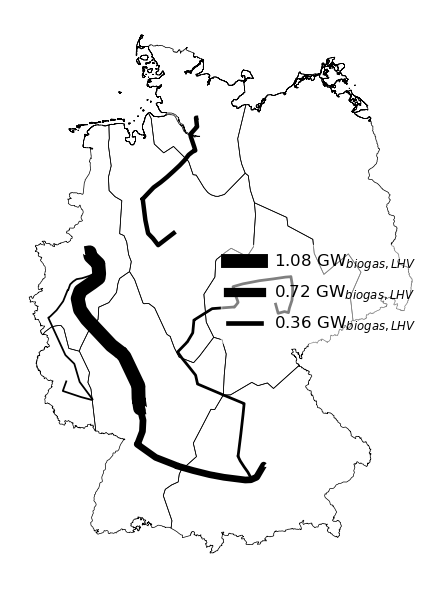

In [58]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "transmissionPipeline.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "Pipelines (biogas)", transFilePath, loc0="loc1", loc1="loc2", fig=fig, ax=ax
)